<a href="https://colab.research.google.com/github/ChandraShekhar-CSR/AI-and-ML/blob/main/Wroksheet_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Task 1: Data Understanding and Visualization:
Download the Provided Data and Complete the following task.

1. Load and visualize images from a dataset stored in directories, where each subdirec-
tory represents a class. You are expected to write a code:

• Get the list of class directories from the train folder.
• Select one image randomly from each class.
• Display the images in a grid format with two rows using matplotlib.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


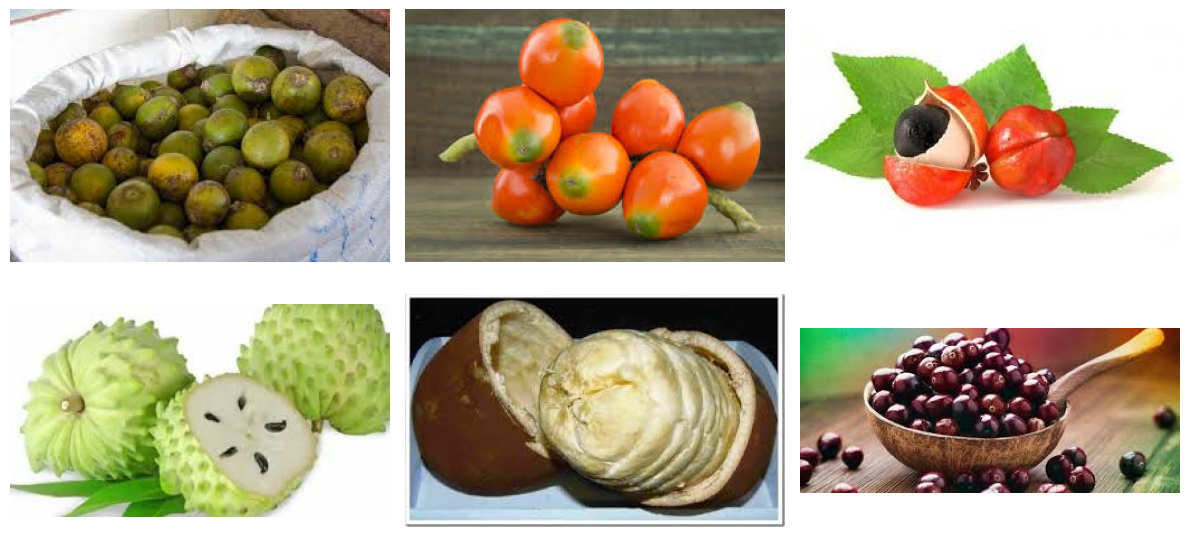

In [5]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

train_folder = '/content/drive/MyDrive/AI and ML/Worksheet5/FruitinAmazon/FruitinAmazon/train'

# Get the list of class directories
class_dirs = [d for d in os.listdir(train_folder) if os.path.isdir(os.path.join(train_folder, d))]

# Select one random image from each class
images = []
for class_dir in class_dirs:
    class_path = os.path.join(train_folder, class_dir)
    image_files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
    if image_files:  # Check if there are any image files in the directory
        random_image = random.choice(image_files)
        image_path = os.path.join(class_path, random_image)
        try:
            img = Image.open(image_path)
            images.append(img)
        except IOError:
            print(f"Error opening image: {image_path}")
    else:
        print(f"No images found in directory: {class_path}")

# Display the images in a grid format
num_images = len(images)
rows = 2
cols = (num_images + 1) // rows  # Calculate the number of columns needed

fig, axes = plt.subplots(rows, cols, figsize=(12, 6))

for i, img in enumerate(images):
    row = i // cols
    col = i % cols
    axes[row, col].imshow(img)
    axes[row, col].axis('off')  # Hide axis ticks and labels

# Hide any remaining empty subplots
for i in range(num_images, rows * cols):
    row = i // cols
    col = i % cols
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()


In [6]:
from PIL import Image
import os

def check_corrupted_images(train_folder):
    corrupted_images = []
    for class_dir in os.listdir(train_folder):
        class_path = os.path.join(train_folder, class_dir)
        if os.path.isdir(class_path):
            for image_file in os.listdir(class_path):
                image_path = os.path.join(class_path, image_file)
                try:
                    img = Image.open(image_path)
                    img.verify() #verify image
                    img.close()
                except (IOError, SyntaxError) as e:
                    corrupted_images.append(image_path)
                    print(f"Removed corrupted image: {image_path}")
                    try:
                        os.remove(image_path)
                    except OSError as e:
                        print(f"Error removing file: {image_path} - {e}")
    if not corrupted_images:
        print("No Corrupted Images Found.")

# Example usage
train_folder = '/content/drive/MyDrive/AI and ML/Worksheet5/FruitinAmazon/FruitinAmazon/train'
check_corrupted_images(train_folder)


No Corrupted Images Found.


Task 2: Loading and Preprocessing Image Data in keras:
In this section, we will load and preprocess image data from a directory using the
image dataset from directory function in Keras.

This function is used to load images from a directory structure where subdirectories represent different
classes. We will also apply basic preprocessing, including resizing and batching and normalization of
images. The same function can be used to load train and validation data.

Found 90 files belonging to 6 classes.
Using 72 files for training.
Class names: ['acai', 'cupuacu', 'graviola', 'guarana', 'pupunha', 'tucuma']
Found 90 files belonging to 6 classes.
Using 18 files for validation.


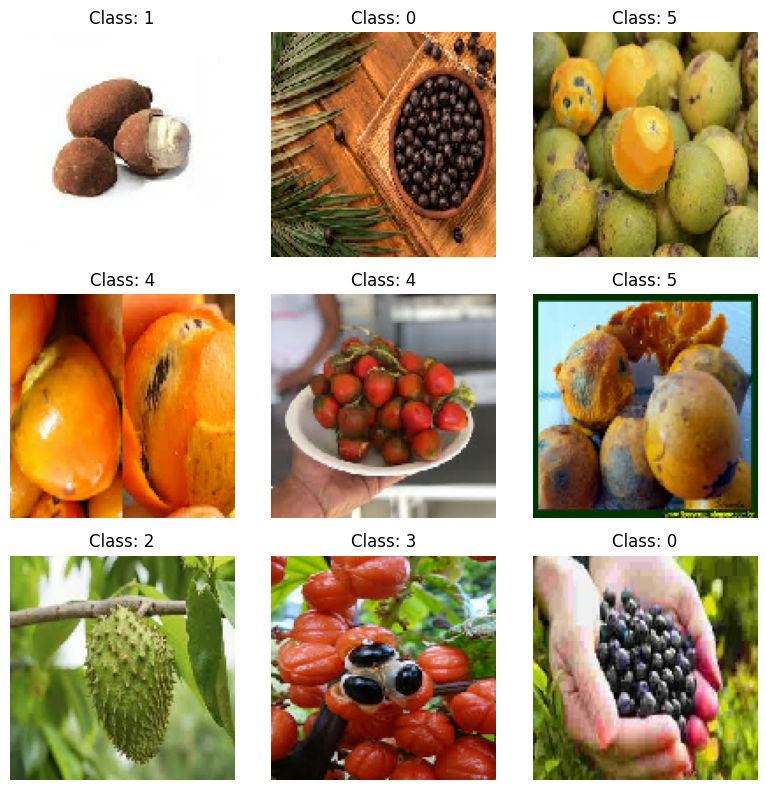

In [16]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Step 1: Set parameters
img_height = 128
img_width = 128
batch_size = 32
validation_split = 0.2
train_dir = "/content/drive/MyDrive/AI and ML/Worksheet5/FruitinAmazon/FruitinAmazon/train"

# Step 2: Normalization layer
rescale = tf.keras.layers.Rescaling(1./255)

# Step 3: Load training dataset (raw version to access class_names)
raw_train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=True,
    validation_split=validation_split,
    subset='training',
    seed=123
)

# Print class names before mapping
print("Class names:", raw_train_ds.class_names)

# Apply normalization
train_ds = raw_train_ds.map(lambda x, y: (rescale(x), y))

# Step 4: Load validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=False,
    validation_split=validation_split,
    subset='validation',
    seed=123
)
val_ds = val_ds.map(lambda x, y: (rescale(x), y))

# Step 5: Visualize one batch
for images, labels in train_ds.take(1):
    plt.figure(figsize=(8, 8))
    for i in range(min(9, len(images))):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(f"Class: {labels[i].numpy()}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()


In [17]:
import tensorflow as tf

# Get number of classes from the training dataset
num_classes = len(raw_train_ds.class_names)

# Build the CNN model
model = tf.keras.models.Sequential([
    # Convolutional Layer 1
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', strides=1, activation='relu', input_shape=(img_height, img_width, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2),

    # Convolutional Layer 2
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', strides=1, activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2),

    # Flatten before fully connected layers
    tf.keras.layers.Flatten(),

    # Fully Connected Layers
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),

    # Output Layer
    tf.keras.layers.Dense(num_classes, activation='softmax')  # Use softmax for multiclass classification
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Show model summary
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       4,194,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 6)                   │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,213,222 (16.07 MB)

 Trainable params: 4,213,222 (16.07 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10  # Adjust based on performance
)


Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 679ms/step - accuracy: 0.1220 - loss: 2.5661 - val_accuracy: 0.8333 - val_loss: 1.4800
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 507ms/step - accuracy: 0.2834 - loss: 1.7288 - val_accuracy: 0.1667 - val_loss: 1.8499
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 525ms/step - accuracy: 0.5217 - loss: 1.5912 - val_accuracy: 0.0000e+00 - val_loss: 1.8881
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.4792 - loss: 1.4080 - val_accuracy: 0.0000e+00 - val_loss: 2.0988
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.6172 - loss: 1.2309 - val_accuracy: 0.3889 - val_loss: 1.4439
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 517ms/step - accuracy: 0.6897 - loss: 0.9906 - val_accuracy: 0.5556 - val_loss: 1.2568
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 498ms/step - accuracy: 0.7687 - loss: 0.8102 - val_accuracy: 0.4444 - val_loss: 1.4796
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 578ms/step - accuracy: 0.8307 - loss: 0.6326 - val_accuracy: 0.8889 - val_los

Task 4: Compile the Model
Model Compilation
• Choose an appropriate optimizer (e.g., Adam), loss function (e.g., sparse categorical crossentropy),
and evaluation metric (e.g., accuracy).
Task 4: Train the Model
Model Training
• Use the model.fit() function to train the model. Set the batch size to 16 and the number of epochs
to 250.
• Use val ds for validation.

• Use callbacks such as ModelCheckpoint and EarlyStopping for saving the best model and avoid-
ing overfitting.

In [19]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

#Rebatch the datasets to batch size 16
train_ds_16 = train_ds.unbatch().batch(16)
val_ds_16 = val_ds.unbatch().batch(16)

#Define callbacks
checkpoint_cb = ModelCheckpoint("best_model.h5", save_best_only=True, monitor='val_loss', mode='min')
earlystop_cb = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

#Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_ds_16,
    validation_data=val_ds_16,
    epochs=250,
    callbacks=[checkpoint_cb, earlystop_cb]
)


Epoch 1/250
      5/Unknown 4s 402ms/step - accuracy: 0.7917 - loss: 0.8410

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 624ms/step - accuracy: 0.7847 - loss: 0.8462 - val_accuracy: 0.6111 - val_loss: 1.5278
Epoch 2/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - accuracy: 0.8146 - loss: 0.6483

5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 370ms/step - accuracy: 0.8177 - loss: 0.6404 - val_accuracy: 0.7222 - val_loss: 0.8793
Epoch 3/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - accuracy: 0.9510 - loss: 0.3705

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 348ms/step - accuracy: 0.9523 - loss: 0.3708 - val_accuracy: 0.8333 - val_loss: 0.6600
Epoch 4/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 316ms/step - accuracy: 0.9737 - loss: 0.2855 - val_accuracy: 0.8333 - val_loss: 0.7346
Epoch 5/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 1.0000 - loss: 0.1161

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 364ms/step - accuracy: 1.0000 - loss: 0.1148 - val_accuracy: 0.8333 - val_loss: 0.4534
Epoch 6/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 945ms/step - accuracy: 1.0000 - loss: 0.0387 - val_accuracy: 0.8333 - val_loss: 0.5895
Epoch 7/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 311ms/step - accuracy: 1.0000 - loss: 0.0263 - val_accuracy: 0.8333 - val_loss: 0.5501
Epoch 8/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 311ms/step - accuracy: 1.0000 - loss: 0.0090 - val_accuracy: 0.8333 - val_loss: 0.5705
Epoch 9/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 318ms/step - accuracy: 1.0000 - loss: 0.0053 - val_accuracy: 0.7778 - val_loss: 0.7366
Epoch 10/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 310ms/step - accuracy: 1.0000 - loss: 0.0029 - val_accuracy: 0.7778 - val_loss: 0.7286
Epoch 11/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 315ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 0.7778 - val_loss: 0.7611
Epoch 12/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 527ms/step - accuracy: 1.0000 - loss: 9.7287e-04 - val_accuracy: 0.7778 - val_lo

Task 5: Evaluate the Model
Model Evaluation
• After training, evaluate the model using model.evaluate() on the test set to check the test
accuracy and loss.

In [20]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(val_ds_16, verbose=2)
print('\nTest accuracy:', test_acc)
print('\nTest loss:', test_loss)

2/2 - 0s - 85ms/step - accuracy: 0.8333 - loss: 0.4534

Test accuracy: 0.8333333134651184

Test loss: 0.45344993472099304


Task 6: Save and Load the Model
Model Saving and Loading
• Save the trained model to an .h5 file using model.save().
• Load the saved model and re-evaluate its performance on the test set.

Task 7: Predictions and Classification Report
Making Predictions
• Use model.predict() to make predictions on test images.
• Convert the model’s predicted probabilities to digit labels using np.argmax().
• Also use from sklearn.metrics import classification report to report the Classification
Report of your Model Performance

Expected Deliverables
• Code Implementation: Complete code for building, training, evaluating, saving, and loading
the model.
• Visualization: Graphs showing the training and validation loss and accuracy.
• Classification Report: Display the final Classification Report on test data.
• Saved Model: Submit the saved .h5 model file.

In [21]:
# Save model as .h5
model.save('fruit_classifier_model.h5')

In [22]:
# Load the saved model
loaded_model = tf.keras.models.load_model('fruit_classifier_model.h5')

In [23]:
# For simplicity, we'll use val_ds for predictions
test_ds = val_ds_16  # already batched at size 16

In [26]:
from sklearn.metrics import classification_report
import numpy as np

# Get all class names from training data
class_names = raw_train_ds.class_names
num_classes = len(class_names)

# Create a list of expected class labels: [0, 1, 2, ..., num_classes-1]
labels = list(range(num_classes))

# Print classification report with labels and class names
print(classification_report(y_true, y_pred, labels=labels, target_names=class_names, zero_division=0))

              precision    recall  f1-score   support

        acai       0.00      0.00      0.00         0
     cupuacu       0.00      0.00      0.00         0
    graviola       0.00      0.00      0.00         0
     guarana       0.00      0.00      0.00         0
     pupunha       1.00      0.67      0.80         3
      tucuma       1.00      0.87      0.93        15

    accuracy                           0.83        18
   macro avg       0.33      0.26      0.29        18
weighted avg       1.00      0.83      0.91        18



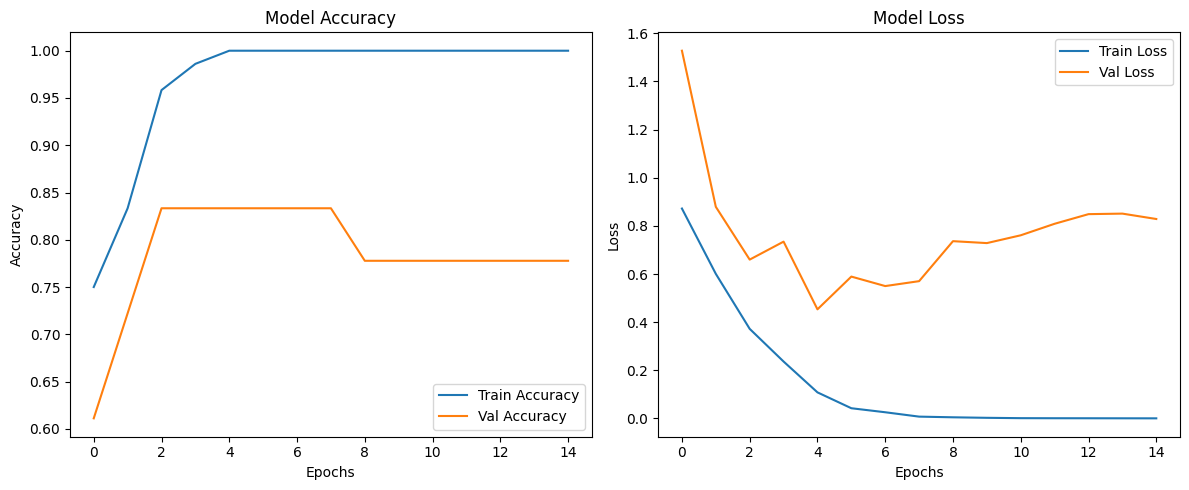

In [28]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()